In [ ]:
import sys
sys.path.append("../scripts")

import data
import utils
import models
import experiments

import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import optuna

## Testing metric with one fold

In [ ]:
args = {
    "dataset" : "german",
    "alpha" : 0.1,
    "n_groups" : 4,
    "model_name" : "M2FGB_eod",
    "n_trials" : 100,
    "thresh" : "ks",
    "fairness_metric" : "min_bal_acc"
}

In [ ]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = data.get_fold("german", 0)
A_train, A_val, A_test = experiments.get_subgroup_feature(
    args["dataset"], X_train, X_val, X_test, args["n_groups"]
)

In [ ]:
col_trans = ColumnTransformer(
    [
        ("numeric", StandardScaler(), data.NUM_FEATURES[args["dataset"]]),
        (
            "categorical",
            OneHotEncoder(
                drop="if_binary", sparse_output=False, handle_unknown="ignore"
            ),
            data.CAT_FEATURES[args["dataset"]],
        ),
    ],
    verbose_feature_names_out=False,
)
col_trans.set_output(transform="pandas")

preprocess = Pipeline([("preprocess", col_trans)])
preprocess.fit(X_train)
X_train = preprocess.transform(X_train)
X_val = preprocess.transform(X_val)
X_test = preprocess.transform(X_test)

In [ ]:
model_class = experiments.get_model(args["model_name"])

In [ ]:
scorer = utils.get_combined_metrics_scorer(
    alpha=args["alpha"], performance_metric="bal_acc", fairness_metric="eod"
)

In [ ]:
study = optuna.create_study(direction="maximize")
objective = lambda trial: experiments.run_trial(
    trial,
    scorer,
    X_train,
    Y_train,
    A_train,
    X_val,
    Y_val,
    A_val,
    model_class,
    experiments.get_param_spaces(args["model_name"]),
    args,
)
study.optimize(objective, n_trials=args["n_trials"])
best_params = study.best_params.copy()

In [ ]:
model = model_class(**study.best_params)
model.fit(X_train, Y_train, A_train)
y_val_score = model.predict_proba(X_val)[:, 1]
thresh = utils.get_best_threshold(Y_val, y_val_score)
y_val_pred = y_val_score > thresh
y_test_score = model.predict_proba(X_test)[:, 1]
y_test_pred = y_test_score > thresh

In [ ]:
eod = utils.equal_opportunity_score(Y_val, y_val_pred, A_val)
min_bal_acc = utils.min_balanced_accuracy(Y_val, y_val_pred, A_val)

print(f"EOD: {eod:.2f}")
print(f"Min. Bal. Acc.: {min_bal_acc:.2f}")
print(f"P(\hat Y = 1): {y_test_pred.mean():.2f}")

In [ ]:
scorer = utils.get_combined_metrics_scorer(
    alpha=args["alpha"], performance_metric="bal_acc", fairness_metric="min_bal_acc"
)
study = optuna.create_study(direction="maximize")
objective = lambda trial: experiments.run_trial(
    trial,
    scorer,
    X_train,
    Y_train,
    A_train,
    X_val,
    Y_val,
    A_val,
    model_class,
    experiments.get_param_spaces(args["model_name"]),
    args,
)
study.optimize(objective, n_trials=args["n_trials"])
best_params = study.best_params.copy()

In [ ]:
model = model_class(**study.best_params)
model.fit(X_train, Y_train, A_train)
y_val_score = model.predict_proba(X_val)[:, 1]
thresh = utils.get_best_threshold(Y_val, y_val_score)
y_val_pred = y_val_score > thresh
y_test_score = model.predict_proba(X_test)[:, 1]
y_test_pred = y_test_score > thresh

In [ ]:
eod = utils.equal_opportunity_score(Y_val, y_val_pred, A_val)
min_bal_acc = utils.min_balanced_accuracy(Y_val, y_val_pred, A_val)

print(f"EOD: {eod:.2f}")
print(f"Min. Bal. Acc.: {min_bal_acc:.2f}")
print(f"P(\hat Y = 1): {y_test_pred.mean():.2f}")

## Tuning M²FGB and FairGBM with min_bal_acc

In [ ]:
n_folds = 10
n_trials = 100

In [ ]:
dataset = "german"
alpha = 0.7
model_name = "M2FGB"
fairness_metric = "min_bal_acc"
thresh = "ks"

args = {
    "dataset": dataset,
    "alpha": alpha,
    "output_dir": f"../results/comparing_metrics/{dataset}/{model_name}_{alpha}_{fairness_metric}",
    "model_name": model_name,
    "n_trials": n_trials,
    "n_groups": 4,
    "thresh" : thresh,
    "n_folds": n_folds,
    "fairness_metric": fairness_metric,
}
experiments.run_subgroup_experiment(args)


dataset = "german"
alpha = 0.7
model_name = "FairGBMClassifier"
fairness_metric = "min_bal_acc"
thresh = "ks"

args = {
    "dataset": dataset,
    "alpha": alpha,
    "output_dir": f"../results/comparing_metrics/{dataset}/{model_name}_{alpha}_{fairness_metric}",
    "model_name": model_name,
    "n_trials": n_trials,
    "n_groups": 4,
    "n_folds": n_folds,
    "thresh" : thresh,
    "fairness_metric": fairness_metric,
}
experiments.run_subgroup_experiment(args)

In [26]:
dataset = "adult"
alpha = 0.7
model_name = "M2FGB"
fairness_metric = "min_bal_acc"
thresh = "ks"

args = {
    "dataset": dataset,
    "alpha": alpha,
    "output_dir": f"../results/comparing_metrics/{dataset}/{model_name}_{alpha}_{fairness_metric}",
    "model_name": model_name,
    "n_trials": n_trials,
    "n_groups": 4,
    "thresh" : thresh,
    "n_folds": n_folds,
    "fairness_metric": fairness_metric,
}
experiments.run_subgroup_experiment(args)



dataset = "adult"
alpha = 0.7
model_name = "FairGBMClassifier"
fairness_metric = "min_bal_acc"
thresh = "ks"

args = {
    "dataset": dataset,
    "alpha": alpha,
    "output_dir": f"../results/comparing_metrics/{dataset}/{model_name}_{alpha}_{fairness_metric}",
    "model_name": model_name,
    "n_trials": n_trials,
    "n_groups": 4,
    "thresh" : thresh,
    "n_folds": n_folds,
    "fairness_metric": fairness_metric,
}
experiments.run_subgroup_experiment(args)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 20%|███████████████████▊                                                                               | 2/10 [01:16<05:16, 39.53s/it]/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 50%|█████████████████████████████████████████████████▌                                                 | 5/10 [04:34<05:19, 63.85s/it]/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [07:54<00:00, 47.43s/it]


In [27]:
fairness_metric = "min_bal_acc"
alpha = 0.5
for dataset in ["german", "adult"]:
    print(f"Results for {dataset}")
    for model_name in ["FairGBMClassifier", "M2FGB"]:
        df = pd.read_csv(f"../results/comparing_metrics/{dataset}/{model_name}_{alpha}_{fairness_metric}/results.csv")

        print(model_name)

        print(f"\tMean bal_acc: {df['bal_acc'].mean():.3f} +- {df['bal_acc'].std():.3f}")
        print(f"\tMean min bal_acc: {df['bal_acc_min'].mean():.3f} +- {df['bal_acc_min'].std():.3f}")
        print(f"\tMean eod: {df['eod'].abs().mean():.3f} +- {df['eod'].abs().std():.3f}")

Results for german
FairGBMClassifier
	Mean bal_acc: 0.648 +- 0.055
	Mean min bal_acc: 0.423 +- 0.225
	Mean eod: 0.517 +- 0.259
M2FGB
	Mean bal_acc: 0.676 +- 0.051
	Mean min bal_acc: 0.423 +- 0.249
	Mean eod: 0.441 +- 0.277
Results for adult
FairGBMClassifier
	Mean bal_acc: 0.825 +- 0.013
	Mean min bal_acc: 0.756 +- 0.018
	Mean eod: 0.150 +- 0.052
M2FGB
	Mean bal_acc: 0.840 +- 0.006
	Mean min bal_acc: 0.751 +- 0.022
	Mean eod: 0.200 +- 0.051


## Experiment with many $\alpha$

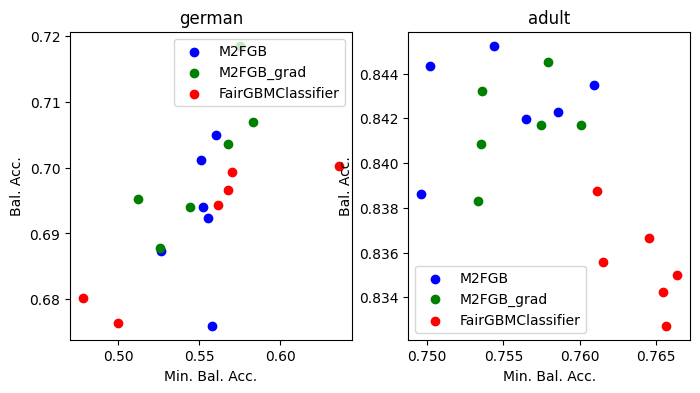

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

colors = {
    "M2FGB": "blue",
    "M2FGB_grad" : "green",
    "FairGBMClassifier": "red"
}

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 4))

fairness_metric = "min_bal_acc"
thresh = "ks"

for i, dataset in enumerate(["german", "adult"]):
    for model_name in ["M2FGB", "M2FGB_grad", "FairGBMClassifier"]:
        bal_acc_min = []
        bal_acc = []
        for alpha in [0, 0.2, 0.4, 0.6, 0.8, 1]:
            df = pd.read_csv(f"../results/comparing_metrics_2/{dataset}/{model_name}_{alpha}_{fairness_metric}/results.csv")
            bal_acc_min.append(df.bal_acc_min.mean())
            bal_acc.append(df.bal_acc.mean())
        axs[i].scatter(
            x = bal_acc_min,
            y = bal_acc,
            color = colors[model_name],
            label = f"{model_name}"
        )

    axs[i].set_xlabel("Min. Bal. Acc.")
    axs[i].set_ylabel("Bal. Acc.")
    axs[i].set_title(dataset)
    axs[i].legend()
plt.show()


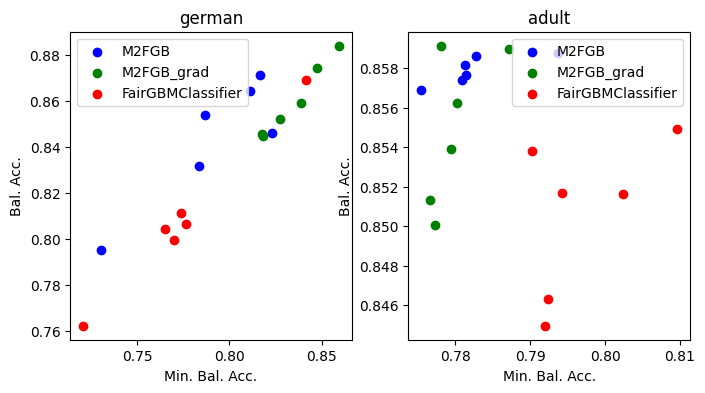

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

colors = {
    "M2FGB": "blue",
    "M2FGB_grad" : "green",
    "FairGBMClassifier": "red"
}

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 4))

fairness_metric = "min_bal_acc"
thresh = "ks"

for i, dataset in enumerate(["german", "adult"]):
    for model_name in ["M2FGB", "M2FGB_grad", "FairGBMClassifier"]:
        bal_acc_min = []
        bal_acc = []
        for alpha in [0, 0.2, 0.4, 0.6, 0.8, 1]:
            df = pd.read_csv(f"../results/comparing_metrics_2/{dataset}/{model_name}_{alpha}_{fairness_metric}/results_train.csv")
            bal_acc_min.append(df.bal_acc_min.mean())
            bal_acc.append(df.bal_acc.mean())
        axs[i].scatter(
            x = bal_acc_min,
            y = bal_acc,
            color = colors[model_name],
            label = f"{model_name}"
        )

    axs[i].set_xlabel("Min. Bal. Acc.")
    axs[i].set_ylabel("Bal. Acc.")
    axs[i].set_title(dataset)
    axs[i].legend()
plt.show()


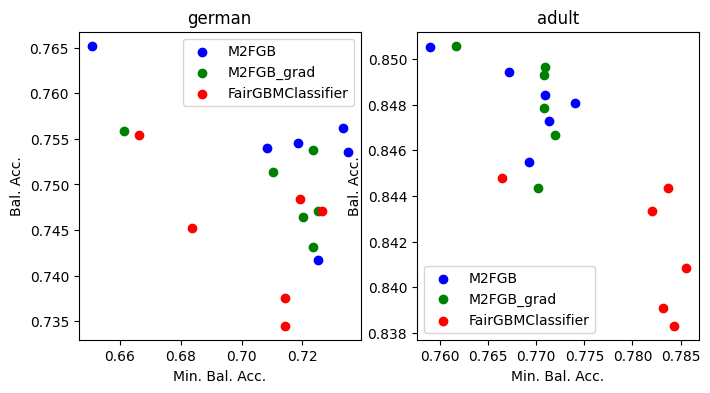

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

colors = {
    "M2FGB": "blue",
    "M2FGB_grad" : "green",
    "FairGBMClassifier": "red"
}

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 4))

fairness_metric = "min_bal_acc"
thresh = "ks"

for i, dataset in enumerate(["german", "adult"]):
    for model_name in ["M2FGB", "M2FGB_grad", "FairGBMClassifier"]:
        bal_acc_min = []
        bal_acc = []
        for alpha in [0, 0.2, 0.4, 0.6, 0.8, 1]:
            df = pd.read_csv(f"../results/comparing_metrics_2/{dataset}/{model_name}_{alpha}_{fairness_metric}/results_val.csv")
            bal_acc_min.append(df.bal_acc_min.mean())
            bal_acc.append(df.bal_acc.mean())
        axs[i].scatter(
            x = bal_acc_min,
            y = bal_acc,
            color = colors[model_name],
            label = f"{model_name}"
        )

    axs[i].set_xlabel("Min. Bal. Acc.")
    axs[i].set_ylabel("Bal. Acc.")
    axs[i].set_title(dataset)
    axs[i].legend()
plt.show()
